In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection


import os
import xmltodict
import numpy as np
from tqdm import tqdm
from PIL import Image

In [124]:
class YOLO_PASCAL_VOC(VOCDetection):
    def __getitem__(self, index):
        """
        전처리
        결과 : X(image), y(label)
        """
        img = Image.open(self.images[index]).convert('RGB').resize((224,224))
        img_transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize((224,224))
        ])
        img = torch.divide(img_transform(img), 255)
        target = xmltodict.parse(open(self.annotations[index], mode='rb'))
        
        classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                   "bus", "car", "cat", "chair", "cow", "diningtable",
                   "dog", "horse", "motorbike", "person", "pottedplant",
                   "sheep", "sofa", "train", "tvmonitor"]
        
        label = np.zeros((7, 7, 25), dtype = float)
        # 격자 구조
        
        Image_Height = float(target['annotation']['size']['height'])
        Image_Width = float(target['annotation']['size']['width'])
        
        try:
            for i, obj in enumerate(target['annotation']['object']):
                if i >= 1:
                    break
    
                class_index = classes.index(obj['name'].lower())
                
                x_min = float(obj['bndbox']['xmin']) 
                y_min = float(obj['bndbox']['ymin'])
                x_max = float(obj['bndbox']['xmax']) 
                y_max = float(obj['bndbox']['ymax'])
                
                x_min = float((224.0/Image_Width)*x_min)
                y_min = float((224.0/Image_Height)*y_min)
                x_max = float((224.0/Image_Width)*x_max)
                y_max = float((224.0/Image_Height)*y_max)
                
                x = (x_min + x_max) / 2.0
                y = (y_min + y_max) / 2.0
                w = x_max - x_min
                h = y_max - y_min
                
                x_cell = int(x/32)
                y_cell = int(y/32)
                
                x_val_inCell = float((x - x_cell * 32.0)/32.0)
                y_val_inCell = float((y - y_cell * 32.0)/32.0)
                
                w = w / 224.0
                h = h / 224.0
                
                
                class_index_inCell = class_index + 5
                
                label[y_cell][x_cell][0] = x_val_inCell
                label[y_cell][x_cell][1] = y_val_inCell
                label[y_cell][x_cell][2] = w
                label[y_cell][x_cell][3] = h
                label[y_cell][x_cell][4] = 1.0
                label[y_cell][x_cell][class_index_inCell] = 1.0
                
    
        # Single-Object in Image
        except TypeError:
            obj = target['annotation']['object']
            class_index = classes.index(obj['name'].lower())
                
            x_min = float(obj['bndbox']['xmin']) 
            y_min = float(obj['bndbox']['ymin'])
            x_max = float(obj['bndbox']['xmax']) 
            y_max = float(obj['bndbox']['ymax'])

            x_min = float((224.0/Image_Width)*x_min)
            y_min = float((224.0/Image_Height)*y_min)
            x_max = float((224.0/Image_Width)*x_max)
            y_max = float((224.0/Image_Height)*y_max)

            x = (x_min + x_max)/2.0
            y = (y_min + y_max)/2.0
            w = x_max - x_min
            h = y_max - y_min

            x_cell = int(x/32) 
            y_cell = int(y/32) 
            x_val_inCell = float((x - x_cell * 32.0)/32.0) 
            y_val_inCell = float((y - y_cell * 32.0)/32.0)

            w = w / 224.0
            h = h / 224.0

            class_index_inCell = class_index + 5

            label[y_cell][x_cell][0] = x_val_inCell
            label[y_cell][x_cell][1] = y_val_inCell
            label[y_cell][x_cell][2] = w
            label[y_cell][x_cell][3] = h
            label[y_cell][x_cell][4] = 1.0
            label[y_cell][x_cell][class_index_inCell] = 1.0

        return img, torch.tensor(label)
            

In [3]:
class YOLO(nn.Module):
    def __init__(self, VGG16):
        super().__init__()
        
        self.backbone = VGG16
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(512), # in_channels
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d(7*7*1024),
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 1470)
        )

    def forward(self, x):
        out = self.backbone(x)
        out = self.conv(out)
        out = self.linear(out)
        out = torch.reshape(out, (-1 ,7, 7, 30))
        return out

In [4]:
def yolo_multitask_loss(y_pred, y_true):
    """
    y_pred : [bounding_box_pred1, bounding_box_pred2, ...]
    y_true : [bounding_box, ...]
    """
    batch_loss = 0
    
    count = len(y_true)
    for i in range(count):
        """
        batch loop
        """
        y_true_unit = y_true[i].clone().detach().requires_grad_(True)
        y_pred_unit = y_pred[i].clone().detach().requires_grad_(True)
        y_true_unit = torch.reshape(y_true_unit, [49, 25])
        y_pred_unit = torch.reshape(y_pred_unit, [49, 30])

        loss = 0.0
        for j in range(0, len(y_true_unit)):
            """
            49: 격자 수
            """
            bbox1_pred = y_pred_unit[j, 0:4].clone().detach().requires_grad_(True)
            bbox1_pred_confidence = y_pred_unit[j, 4].clone().detach().requires_grad_(True)
            bbox2_pred = y_pred_unit[j, 5:9].clone().detach().requires_grad_(True)
            bbox2_pred_confidence = y_pred_unit[j, 9].clone().detach().requires_grad_(True)
            
            class_pred = y_pred_unit[j, 10:].clone().detach().requires_grad_(True)
            
            bbox_true = y_true_unit[j, :4].clone().detach().requires_grad_(True)
            bbox_true_confidence = y_true_unit[j, 4].clone().detach().requires_grad_(True)
            class_true = y_true_unit[j, 5:].clone().detach().requires_grad_(True)

            # IoU
            box_pred_1_np = bbox1_pred.detach().numpy()
            box_pred_2_np = bbox2_pred.detach().numpy()
            box_true_np = bbox_true.detach().numpy()

            bbox_true = y_true_unit[j, :4].clone().detach().requires_grad_(True)
            bbox_true_confidence = y_true_unit[j, 4].clone().detach().requires_grad_(True)
            class_true = y_true_unit[j, 5:].clone().detach().requires_grad_(True)

            # 바운딩 박스 좌표에서 [min_x, min_y, max_x, max_y]
            box_pred_1_minmax = np.asarray([box_pred_1_np[0] - 0.5*box_pred_1_np[2], box_pred_1_np[1] - 0.5*box_pred_1_np[3], box_pred_1_np[0] + 0.5*box_pred_1_np[2], box_pred_1_np[1] + 0.5*box_pred_1_np[3]])
            box_pred_2_minmax = np.asarray([box_pred_2_np[0] - 0.5*box_pred_2_np[2], box_pred_2_np[1] - 0.5*box_pred_2_np[3], box_pred_2_np[0] + 0.5*box_pred_2_np[2], box_pred_2_np[1] + 0.5*box_pred_2_np[3]])
            box_true_minmax   = np.asarray([box_true_np[0] - 0.5*box_true_np[2], box_true_np[1] - 0.5*box_true_np[3], box_true_np[0] + 0.5*box_true_np[2], box_true_np[1] + 0.5*box_true_np[3]])

            # [max(pred_x_min, true_x_min), max(pred_y_min, true_y_min), min(pred_x_max, true_x_max), min(pred_y_max, true_y_max)]
            InterSection_pred_1_with_true = [max(box_pred_1_minmax[0], box_true_minmax[0]), max(box_pred_1_minmax[1], box_true_minmax[1]), min(box_pred_1_minmax[2], box_true_minmax[2]), min(box_pred_1_minmax[3], box_true_minmax[3])]
            InterSection_pred_2_with_true = [max(box_pred_2_minmax[0], box_true_minmax[0]), max(box_pred_2_minmax[1], box_true_minmax[1]), min(box_pred_2_minmax[2], box_true_minmax[2]), min(box_pred_2_minmax[3], box_true_minmax[3])]


            IntersectionArea_pred_1_true = 0
            if (InterSection_pred_1_with_true[2] - InterSection_pred_1_with_true[0] + 1) >= 0 and (InterSection_pred_1_with_true[3] - InterSection_pred_1_with_true[1] + 1) >= 0 :
                width = InterSection_pred_1_with_true[2] - InterSection_pred_1_with_true[0] + 1
                height = InterSection_pred_1_with_true[3] - InterSection_pred_1_with_true[1] + 1
                IntersectionArea_pred_1_true = width * height
            else:
                IntersectionArea_pred_1_true = 0.0
            
            IntersectionArea_pred_2_true = 0.0
            if (InterSection_pred_2_with_true[2] - InterSection_pred_2_with_true[0] + 1) >= 0 and (InterSection_pred_2_with_true[3] - InterSection_pred_2_with_true[1] + 1) >= 0 :
                IntersectionArea_pred_2_true = (InterSection_pred_2_with_true[2] - InterSection_pred_2_with_true[0] + 1) * (InterSection_pred_2_with_true[3] - InterSection_pred_2_with_true[1] + 1)
            else:
                IntersectionArea_pred_2_true = 0.0
            
            box_pred_1_area = (box_pred_1_minmax[2] - box_pred_1_minmax[0] + 1) * (box_pred_1_minmax[3] - box_pred_1_minmax[1] + 1)
            box_pred_2_area = (box_pred_2_minmax[2] - box_pred_2_minmax[0] + 1) * (box_pred_2_minmax[3] - box_pred_2_minmax[1] + 1)
            box_true_area = (box_true_minmax[2] - box_true_minmax[0] + 1) * (box_true_minmax[3] - box_true_minmax[1] + 1)
            
            Union_pred_1_true = box_pred_1_area + box_true_area - IntersectionArea_pred_1_true
            Union_pred_2_true = box_pred_2_area + box_true_area - IntersectionArea_pred_2_true

            IoU_box_1 = IntersectionArea_pred_1_true/Union_pred_1_true
            IoU_box_2 = IntersectionArea_pred_2_true/Union_pred_2_true

            responsible_box = torch.zeros(4)
            responsible_bbox_confidence = 0
            non_responsible_bbox_confidence = 0

            if IoU_box_1 >= IoU_box_2 :
                responsible_box = bbox1_pred.clone().detach().requires_grad_(True)
                responsible_bbox_confidence = bbox1_pred_confidence.clone().detach().requires_grad_(True)
                non_responsible_bbox_confidence = bbox2_pred_confidence.clone().detach().requires_grad_(True)
                                
            else :
                responsible_box = bbox2_pred.clone().detach().requires_grad_(True)
                responsible_bbox_confidence = bbox2_pred_confidence.clone().detach().requires_grad_(True)
                non_responsible_bbox_confidence = bbox1_pred_confidence.clone().detach().requires_grad_(True)
            
            obj_exist = torch.ones_like(bbox_true_confidence)
            if box_true_np[0] == 0.0 and box_true_np[1] == 0.0 and box_true_np[2] == 0.0 and box_true_np[3] == 0.0 : 
                obj_exist = torch.zeros_like(bbox_true_confidence) 

            localization_err_x = torch.pow( torch.subtract(bbox_true[0], responsible_box[0]), 2) 
            localization_err_y = torch.pow( torch.subtract(bbox_true[1], responsible_box[1]), 2) 

            localization_err_w = torch.pow( torch.subtract(torch.sqrt(bbox_true[2]), torch.sqrt(responsible_box[2])), 2) 
            localization_err_h = torch.pow( torch.subtract(torch.sqrt(bbox_true[3]), torch.sqrt(responsible_box[3])), 2) 

            if torch.isnan(localization_err_w).detach().numpy() == True :
                localization_err_w = torch.zeros_like(localization_err_w)
            
            if torch.isnan(localization_err_h).detach().numpy() == True :
                localization_err_h = torch.zeros_like(localization_err_h)
            
            localization_err_1 = torch.add(localization_err_x, localization_err_y)
            localization_err_2 = torch.add(localization_err_w, localization_err_h)
            localization_err = torch.add(localization_err_1, localization_err_2)
            
            weighted_localization_err = torch.multiply(localization_err, 5.0)    
            weighted_localization_err = torch.multiply(weighted_localization_err, obj_exist)

            class_confidence_score_obj = torch.pow(torch.subtract(responsible_bbox_confidence, bbox_true_confidence), 2)
            class_confidence_score_obj = torch.mul(class_confidence_score_obj, obj_exist)
            
            class_confidence_score_noobj = torch.pow(torch.subtract(non_responsible_bbox_confidence, torch.zeros_like(bbox_true_confidence)), 2)
            class_confidence_score_noobj = torch.multiply(class_confidence_score_noobj, 0.5)
            class_confidence_score_noobj = torch.mul(class_confidence_score_noobj, torch.subtract(torch.ones_like(obj_exist), obj_exist))

            class_confidence_score = torch.add(class_confidence_score_obj,  class_confidence_score_noobj) 


            classification_err = torch.pow(torch.subtract(class_true, class_pred), 2.0)
            classification_err = torch.sum(classification_err)
            classification_err = torch.multiply(classification_err, obj_exist)

            loss_OneCell_1 = torch.add(weighted_localization_err, class_confidence_score)
            
            loss_OneCell = torch.add(loss_OneCell_1, classification_err)

            if loss == 0 :
                loss = loss_OneCell.clone().detach().requires_grad_(True)
            else :
                loss = torch.add(loss, loss_OneCell)
        


        if batch_loss == 0:
            batch_loss = loss.clone().detach().requires_grad_(True)
            batch_loss = torch.divide(batch_loss, count) # 평균 오차 구하기
        else:
            batch_loss = torch.add(batch_loss, torch.divide(loss, count))
    
    return batch_loss

In [5]:
def train_YOLO(YOLO_model, criterion, optimizer, scheduler, epochs, data_loader, device) :
    YOLO_model.train() # Train mode 진입!
    
    pbar = tqdm(range(epochs), desc="training", mininterval=0.01)
    
    best_loss = float('inf')
    for epoch in pbar:
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
             
            outputs = YOLO_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()

            # 배치로 학습시킬 때마다 loss 보여주기
            pbar_str = "training, [loss = %.4f]" % loss.item()
            pbar.set_description(pbar_str)
            
            # Save best model
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(YOLO_model.state_dict(), "./yolov1.pt")
        # lr decay
        scheduler.step()
    
    # Return best model
    YOLO_model.load_state_dict(torch.load("./yolov1.pt"))
    return model

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

current_path = os.getcwd()
path2data = current_path + '/voc'
if not os.path.exists(path2data): 
    os.mkdir(path2data)
    
BATCH_SIZE = 64
EPOCH = 135

Train_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='train', download=True)
Test_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='test', download=True)

data_loader = torch.utils.data.DataLoader(dataset=Train_Dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)
                                          

Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc
Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc


In [92]:
VGGNet = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)


for i in range(len(VGGNet.features[:-1])) :
    if type(VGGNet.features[i]) == type(nn.Conv2d(64,64,3)) :
        VGGNet.features[i].weight.requires_grad = False
        VGGNet.features[i].bias.requires_grad = False
        VGGNet.features[i].padding = 1

backbone = VGGNet.features[:-1]
YOLO_model =  YOLO(backbone).to(device) # Create YOLO model
optimizer = torch.optim.SGD(YOLO_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


if os.path.exists('./yolov1.pt'):
    YOLO_model.load_state_dict(torch.load("./yolov1.pt"))

YOLO_model = train_YOLO(YOLO_model, yolo_multitask_loss, optimizer, scheduler, EPOCH, data_loader, device)

Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtrainval_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc
Using downloaded and verified file: /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar
Extracting /Users/teddy/BearTeam/edu/model/voc/VOCtest_06-Nov-2007.tar to /Users/teddy/BearTeam/edu/model/voc


Using cache found in /Users/teddy/.cache/torch/hub/pytorch_vision_v0.10.0
training, [loss = 22.0542]:   0%|                       | 0/135 [02:21<?, ?it/s]


KeyboardInterrupt: 

In [87]:
# https://wolfy.tistory.com/259
def decode(y_pred):
    """
    y_pred : [S x S x (B x 5 + C)] shape
             B : [x, y, w, h, c, classes]
    
    Returns :
        boxes : [[x_center, y_center, w, h] for obj1, ...]
               [n_boxes, 4] shape 
        labels : class label!
                [n_boxes, ] shape
        confidences : objectness confidence
                      [n_boxes, ] shape
        class_score : scores for class
                      [n_boxes, ] shape
    
    Docs:
        최대 S x S 개의 Bounding Box를 찾을 수 있다!
        격자 하나 당 하나의 Bounding Box가 예측된다.
    """
    S = 7
    B = 2
    C = 20
    
    confidence_threshold = 0.1
    prob_threshold = 0.1
    nms_threshold = 0.5
    
    boxes, labels, confidences, class_scores = [], [], [], []
    
    confidence = y_pred[..., 4].unsqueeze(2) # [7 x 7 x 1] shape
    for b in range(1, B):
        confidence = torch.cat((confidence, y_pred[..., 5*b + 4].unsqueeze(2)), 2) # [7 x 7 x B] shape

    # threshold를 넘어야 confidence를 고려하기
    confidence.apply_(lambda c: c if c > confidence_threshold else 0.0)
    
    for y_cell in range(S):
        for x_cell in range(S):
            class_score, class_label = torch.max(y_pred[y_cell, x_cell, 5*B:], 0)

            for b in range(B):
                probability = confidence[y_cell, x_cell, b] * class_score
                
                # 확률이 작으면 무시
                if float(probability) < prob_threshold:
                    continue
                else:
                    x, y, w, h = y_pred[y_cell, x_cell, 5*b : 5*b + 4]
                    
                    print(x, y, w, h)
                    # 실제 x, y 좌표 구하기
                    x = 32.0 * (x + x_cell)
                    y = 32.0 * (y + y_cell)
                    
                    # 실제 w, h 좌표 구하기
                    w = w * 224.0
                    h = h * 224.0
                    
                    boxes.append(torch.FloatTensor([x, y, w, h]))
                    labels.append(torch.FloatTensor([class_label]))
                    confidences.append(torch.FloatTensor(confidence))
                    class_scores.append(torch.FloatTensor([class_score]))

        if len(boxes) > 0:
            boxes = torch.stack(boxes, 0) # [n_boxes, 4] shape
            labels = torch.stack(labels, 0) # [n_boxes, ] shape
            confidences = torch.stack(confidences, 0) # [n_boxes, ] shape
            class_scores = torch.stack(class_scores, 0) # [n_boxes, ] shape
        else:
            # No Bounding Box
            boxes = torch.FloatTensor(0, 4)
            labels = torch.FloatTensor(0)
            confidences = torch.FloatTensor(0)
            class_scores = torch.FloatTensor(0)
        
        return boxes, labels, confidences, class_scores
            

In [133]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect(YOLO_model, x):
    """
    x : [224 x 224 x 3] 크기의 Image
    
    Returns:
        {
            img: input image
            bbox: [n_boxes, 4] tensor
            labels: [n_boxes, ] tensor
            confidences = [n_boxes, ] tensor
            class_scores = [n_boxes, ] tensor
        }
    """
    
    out = dict()
    img = x.squeeze(0).detach()
    # transpose와 reshape의 차이점을 기록하쟈!
    img = torch.transpose(img, 0, 1).transpose(1, 2) # [channel, width, height] => [width, height, channel]
    
    YOLO_model.eval() # Evaluation Model 진입
    with torch.no_grad(): # Gradient 계산 안하기!
        y_pred = YOLO_model(x)
        boxes, labels, confidences, class_scores = decode(y_pred.squeeze(0))
        
        out = {
            'img': img, 
            'bbox': boxes,
            'labels': labels,
            'confidences': confidences,
            'class_scores': class_scores
        }
    return out

def draw(obj):
    """
    obj : {
        img: input image(RGB)
        bbox: [n_boxes, 4] tensor
        labels: [n_boxes, ] tensor
        confidences = [n_boxes, ] tensor
        class_scores = [n_boxes, ] tensor
    }
    """
    
    plt.title("YOLOv1")
    plt.imshow(obj['img'])
    ax = plt.gca()
    
    def clip(x):
        if x < 0.0:
            x = 0.0
        elif x > 224.0:
            x = 224.0
        return x
    
    for idx, (x, y, w, h) in enumerate(obj['bbox']):
        # Clip
        clip(x)
        clip(y)
        clip(w)
        clip(h)
        
        x_min = x - w * 0.5
        y_min = y - h * 0.5
        
        x_max = x + w * 0.5
        y_max = y + h * 0.5
        
        clip(x_min)
        clip(x_max)
        clip(y_min)
        clip(y_max)
        
        rect = patches.Rectangle((x_min, y_min),
                                w,
                                h,
                                linewidth=2,
                                edgecolor='red',
                                fill=False,)
        ax.add_patch(rect)
        plt.annotate(f"label:{obj['labels'][idx]} \n score: {obj['class_scores'][idx]}", (x_max, y_max))
        
    plt.show()
        

tensor(-0.0464) tensor(-0.1648) tensor(0.1870) tensor(0.3968)
tensor(0.0976) tensor(-0.7100) tensor(0.3708) tensor(0.0957)
tensor(0.3619) tensor(-0.7155) tensor(0.5303) tensor(-0.0312)
tensor(0.1208) tensor(-0.1520) tensor(-0.1862) tensor(0.1510)


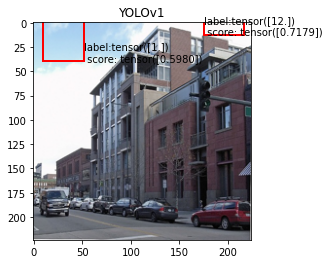

In [134]:
# 예측해보기
YOLO_model.load_state_dict(torch.load("./yolov1.pt"))
img, label = Test_Dataset[3]

out = detect(YOLO_model, img.unsqueeze(0))

draw(out)